# Explorando convolução no PyTorch

O objetivo deste notebook é de explorar a convolução que é implementada pelo PyTorch.

A convolução é a operação essencial das redes convolucionais. É uma operação demorada e a sua implementação na GPU acelera bastante o seu processamento. A implementação é feita no PyTorch utilizando GPU. Se a GPU não for encontrada, a implementação roda na CPU.

[A guide to convolution arithmetic for deep
learning by Vincent Dumoulin and Francesco Visin, 2016](https://arxiv.org/pdf/1603.07285.pdf)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import torch

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: False


# Uma rede com uma única camada convolucional

O objetivo deste experimento é explorar numericamente a convolução implementada na rede
convolucional do PyTorch. Para isso iremos criar uma rede convolucional com apenas
uma camada de convolução. A sua predição será o resultado da rede, que neste caso será apenas uma convolução.

Uma convolução pode ser visto como uma média móvel ponderada sobre a imagem. A equação matemática da convolução é dada por:

$$ \boldsymbol{Y} = \boldsymbol{X} \ast \boldsymbol{W} $$

onde $\boldsymbol{X}$ é a imagem de entrada, $\boldsymbol{Y}$ é o resultado da convolução e $\boldsymbol{W}$ é chamado de peso,
núcleo, máscara, entre outros nomes. A convolução é a implementação de filtro linear
invariante à translação. Este filtro é totalmente especificado pelo núcleo (array $\boldsymbol{W}$) que
contém os parâmetros do filtro linear (da rede convolucional) que precisam ser treinados.

A figura a seguir ilustra uma convolução da imagem verde de entrada, utilizando o núcleo da convolução (kernel) em amarelo, deslizando sobre a imagem verde. O resultado da convolução é a imagem rosa, de tamanho ligeiramente menor, devido ao processamento na borda da imagem.

![](http://mourafiq.com/images/posts/convolution_schematic.gif)

## Organização dos dados de entrada

As convoluções do PyTorch foram projetadas principalmente para tratar imagens ou sons. Assim, a organização dos arrays da imagem de entrada, de saída e dos pesos são feitos de forma específica para atender às necessidades das redes convolucionais. Iremos ilustrar as convoluções utilizando imagem de entrada em nível de cinza e coloridas com 3 bandas, usando a convenção do *shape* de imagens. 

As representação usuais (não convolucionais), onde a organização da matriz $\boldsymbol{X}$ de entrada é bidimensional, com $M$ amostras nas linhas e $M$ *features* nas colunas, têm shape de $\boldsymbol{X}$ igual a:

$ \boldsymbol{X_{M,N}}:$ `(n_samples, n_features)`
 
No caso de imagens, como elas têm natureza bidimensional, a relação de vizinhança entre os pixels é fundamental, principalmente
para que os pesos dos núcleo abranjam uma região bidimensional da imagem. Assim, as *features* passam agora a terem duas dimensões. São $N$ pixels organizados em `(img_height, img_width)`. Desta forma o array passa a ter uma nova dimensão: 

$ \boldsymbol{X}:$ `(n_samples, img_height, img_width)`

Numa imagem em nível de cinza temos apenas um valor para representar o pixel, que é sua intensidade, variando de escuro a claro. Quando a imagem é colorida, são necessários 3 valores
para cada pixel. No PyTorch, este 3 valores são organizados em uma dimensão adicional, denominada canal *channel* ou banda. A imagem colorida é então representada com *shape*:`(bandas, img_height, img_width)`. Portanto, o *shape* de entrada deve ter 4 dimensões:

$ \boldsymbol{X}:$ `(n_samples, n_channels, img_height, img_width)`

![](../figures/image_representation.png)

## Organização dos pesos (kernel) da convolução

Os pesos do kernel da convolução para tratar imagens devem ser 2D, quando a imagem
de entrada for em nível de cinza e devem ter 3 bandas 2D para imagens coloridas. Assim, a organização
do *shape* do kernel é $(bands, k_{height}, k_{width})$. Entretanto, nas arquiteturas das redes
convolucionais, é usual definir vários filtros (vários kernels), para que a rede tenha um
maior número de parâmetros a serem ajustados. Assim, o shape dos pesos devem ter 4 dimensões:

$\boldsymbol{W}:$ `(nb_filters, channels, k_height, k_width)`

Observe que a primeira dimensão (`nb_filters`) diz respeito ao número de filtros na saída,
enquanto que as três demais dimensões `(channels, k_height, k_width)` à janela deslizante
(*kernel*) da convolução.

Esta representação também pode ser vista da seguinte forma:

$\boldsymbol{W}:$ `(nb_outputs, nb_inputs, k_height, k_width)`

onde

- `nb_outputs` = número de imagens que serão geradas por amostra (sample) na saída

- `nb_inputs` = número de imagens que são fornecidas por amostra (sample) na entrada

- `(k_height, k_width)` = dimensões do kernel



## Organização da imagem de saída (filtrada)

A organização da imagem de saída é a mesma da imagem de entrada, até porque a camada convolucional pode ser colocada não apenas na entrada, mas como qualquer camada interna da
rede. A principal diferença está na nomenclatura da segunda dimensão: enquanto que na
imagem da camada de entrada a segunda dimensão é o *channel*, isto é o número de bandas 
da imagem colorida, na saída e demais camadas, a segunda dimensão passa a ser o número de
filtros aplicados naquela camada. Assim, o *shape* da imagem de saída fica como:

$\boldsymbol{Y}: $` (samples, filtros, img_height, img_width)`

## Exercícios rápidos - análise da convolução

### Análise do comprimento e largura das imagens na convolução

1. Se $X$ tem dimensão (1, 1, 4, 4) e o Kernel (1, 1, 3, 3) qual é a dimensão da saída $Y$?

2. E se $X$ tem dimensão (1, 1, 10, 6) e o Kernel (1, 1, 5, 3) qual é a dimensão da saída $Y$?

3. Qual é a relação de `img_height` e `img_width` da saída com o comprimento e largura de $X$ e do Kernel? 

Respostas:
1. $\boldsymbol{Y}:$ (?,?,?,?)
2. $\boldsymbol{Y}:$ (?,?,?,?)
3.  - `y_img_height` = x_img_height ? k_height
    - `y_img_width` = x_img_width ? k_width

### Análise das dimensões de saída para mais de uma banda (channel)

1. Se $X$ tem dimensão (1024, 3, 4, 4) e o Kernel (10, 3, 3, 3) qual deve ser a dimensão da saída $Y$?

2. Se $X$ tem dimensão (20, 3, 5, 5) qual deve ser a dimensão do Kernel para que a saída $Y$ tenha dimensão (20, 5, 2, 2)?

Respostas:
1. $\boldsymbol{Y}:$ (?,?,?,?)
2. $\boldsymbol{W}:$ (?,?,?,?)

Ilustração da convolução do primeiro exercício.
![](../figures/no_padding_no_strides.gif)

## Zero padding

Esta próxima figura ilustra a convolução quando a imagem de saída (em verde) é igual às
dimensões da imagem de entrada (em azul). Neste caso, a imagem de entrada é artificialmente
aumentada com valores zeros. Este processo de aumentar a imagem de entrada com zeros é 
denominado *zero padding*.

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)

## Analisando as convoluções em uma rede convolucional típica

Veja a rede a seguir com 4 camadas convolucionais:

![](../figures/architecture.png)
Fonte: [Figura apresentação do Sander Dieleman](http://benanne.github.io/images/architecture.png)

A imagem de entrada é uma imagem colorida
quadrada de 45 pixels de lado. Utiliza-se um kernel de 6x6 gerando 32 filtros, então os *shapes* são:
* Camada 1:
    - entrada: (amostras, 3, 45, 45)
    - kernel:  (32, 3, 6, 6)
    - saída: (amostras, 32, 40, 40) Obs: a imagem de saída fica menor
* Camada 2:
    - entrada: (amostras, 32, 40, 40) Obs: é a imagem de saída da camada anterior
    - kernel: (64, 32, 5, 5)
    - saída: (amostras, 64, 16, 16)
* Camada 3:
    - entrada: (amostras, 64, 16, 16)
    - kernel: (128, 64, 3, 3)
    - saída: (amostras, 128, 6, 6)
* Camada 4:
    - entrada: (amostras 128, 6, 6)
    - kernel: (128, 128, 3, 3)
    - saída: (amostras, 128, 4, 4)
    
## Cálculo do número de parâmetros no núcleos das convoluções

O número de parâmetros de cada convolução é igual ao número de elementos do kernel,
contabilizando todas as suas dimensões. Assim, um kernel de *shape* (10, 3, 5, 5) terá 750 elementos.

Como exercício, calcule o número de elementos dos kernels de cada uma das 4 camadas da rede
ilustrativa e o total de elementos.

Resposta:
- Camada 1:
- Camada 2:
- Camada 3:
- Camada 4:
- Total:

## Ilustrações da convolução

### Convolução com mais de uma banda

O Kernel precisa ter o mesmo número de bandas da imagem, cada banda da imagem é convoluida com a sua correspondente no Kernel. As convoluções são então somadas posição a posição para formar a saída.

![](../figures/Convolution_channels.png)


### Convolução com mais de um filtro

No caso em qua há mais de um filtro, a operação com a imagem acima é realizada para cada filtro.

![](../figures/Convolution_many_filters.png)



### Próximas camadas

Nas próximas camadas da rede o conjunto de entrada é a saída da convolução anterior. A operação realizada é a mesma acima.

![](../figures/Convolution_many_filters_cont.png)


Lembrando que essas operações são realizadas para cada imagem (sample) da entrada.

## Definição da convolução usando PyTorch

A implementação da convolução utiliza um modelo sequencial do PyTorch com `Conv2D`.
Obtemos o resultado da rede pela função `predict`:

In [3]:
# 4-D convolution
def conv2d(X, W, padding=0):
    """
    Faz a convolução de um conjunto de imagens com um Kernel com pesos expecificados.

    Parâmetros
    ----------
    X : numpy array (4 dimensões): (n_samples, n_channels, img_height, img_width)
        Imagens de entrada.
    W : numpy array (4 dimensões): (n_filtros, n_channels, kernel_height, kernel_width)
        Kernel que será utilizado para realizar a convolução
    padding : int:
        Zero padding que será utilizado na imagem para realizar a convolução.
        
    Retorno
    -------
    Y : numpy array (4 dimensões): (n_samples, n_channels, img_height, img_width)
        Imagens resultantes da convolução
        
    """
    import torch.nn.functional as F
    from torch.autograd import Variable
    
    assert X.ndim == 4
    assert W.ndim == 4
    
    # Tranforma em tensores torch
    X = torch.FloatTensor(X.astype(float))
    W = torch.FloatTensor(W.astype(float))
    
    # Coloca na GPU se estiver disponível
    if use_gpu:
        X = X.cuda()
        W = W.cuda()
    
    # Encapsula em variáveis
    X = Variable(X)
    W = Variable(W)

    # Faz a convolução
    conv = F.conv2d(X, W, padding=padding, bias=None)
    
    # Transforma o resultado de volta em numpy
    return conv.data.cpu().numpy()

## Primeiro caso, resposta ao impulso

Esta é uma forma usual para se verificar se a convolução está funcionando. Quando a imagem de entrada é apenas um 1 rodeado de vários zeros, o resultado da convolução é o próprio kernel posicionado no local do 1? 

Teoricamente é o que deveria acontecer, porém o que chamamos de convolução neste notebook é na verdade é uma relação cruzada (cross-correlation). Durante o treinamento da rede convulucional o resultado é o mesmo nas duas notações. E na maior parte da literatura sobre Deep Learning o termo *convolução* se refere ao que utilizamos aqui. 

Assim, utilizaremos uma imagem cinza 3x5 com um "1" no centro. O kernel é de 2 linhas e 3 colunas. O resultado é uma imagem 3x5 com o kernel posicionado no local do 1 da imagem de entrada, porém invertido horizontalmente e verticalmente.

In [4]:
#np.set_printoptions(suppress=True, precision=3)

x = np.array([[0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0]]).reshape(1,1,5,7)
W = np.array([[1.,2.,3.],
              [4.,5.,6.]]).reshape(1,1,2,3)

y = conv2d(x, W, 0)

print('x.shape:', x.shape)
print(x)
print('W.shape:', W.shape)
print(W)
print('y.shape:', y.shape)
print(y)

x.shape: (1, 1, 5, 7)
[[[[0 0 0 0 0 0 0]
   [0 0 0 0 0 0 0]
   [0 0 0 1 0 0 0]
   [0 0 0 0 0 0 0]
   [0 0 0 0 0 0 0]]]]
W.shape: (1, 1, 2, 3)
[[[[ 1.  2.  3.]
   [ 4.  5.  6.]]]]
y.shape: (1, 1, 4, 5)
[[[[ 0.  0.  0.  0.  0.]
   [ 0.  6.  5.  4.  0.]
   [ 0.  3.  2.  1.  0.]
   [ 0.  0.  0.  0.  0.]]]]


## Reproduzindo o exemplo da figura animada
![](http://mourafiq.com/images/posts/convolution_schematic.gif)

In [5]:
x = np.array([[1,1,1,0,0],
              [0,1,1,1,0],
              [0,0,1,1,1],
              [0,0,1,1,0],
              [0,1,1,0,0]]).reshape(1,1,5,5)
W = np.array([[1,0,1],
              [0,1,0],
              [1,0,1]]).reshape(1,1,3,3)

y = conv2d(x, W, 0)

print('x.shape:', x.shape)
print(x)
print('W.shape:', W.shape)
print(W)
print('y.shape:', y.shape)
print(y)

x.shape: (1, 1, 5, 5)
[[[[1 1 1 0 0]
   [0 1 1 1 0]
   [0 0 1 1 1]
   [0 0 1 1 0]
   [0 1 1 0 0]]]]
W.shape: (1, 1, 3, 3)
[[[[1 0 1]
   [0 1 0]
   [1 0 1]]]]
y.shape: (1, 1, 3, 3)
[[[[ 4.  3.  4.]
   [ 2.  4.  3.]
   [ 2.  3.  4.]]]]


## 4 amostras de entrada imagem cinza 3x5, 1 filtro de saída com kernel de 3x3 

Neste caso, 
- shape da entrada, x:(4,1,3,5)
- shape dos pesos W:(1, 1, 3,3). 
- shape de saída será y:(4,1,3,5)

In [6]:
W = np.array([[1,0,1],
              [0,1,0],
              [1,0,1]]).reshape(1,1,3,3)
# criando 4 amostras de imagens
x = np.array([[0,0,0,0,0],
              [0,0,1,0,0],
              [0,0,0,0,0]]).reshape(1,1,3,5) * np.arange(1,5).reshape(4,1,1,1)
y = conv2d(x, W, 1)
print('x.shape:', x.shape)
print(x)
print('W.shape:', W.shape)
print(W)
print('y.shape:', y.shape)
print(y)

x.shape: (4, 1, 3, 5)
[[[[0 0 0 0 0]
   [0 0 1 0 0]
   [0 0 0 0 0]]]


 [[[0 0 0 0 0]
   [0 0 2 0 0]
   [0 0 0 0 0]]]


 [[[0 0 0 0 0]
   [0 0 3 0 0]
   [0 0 0 0 0]]]


 [[[0 0 0 0 0]
   [0 0 4 0 0]
   [0 0 0 0 0]]]]
W.shape: (1, 1, 3, 3)
[[[[1 0 1]
   [0 1 0]
   [1 0 1]]]]
y.shape: (4, 1, 3, 5)
[[[[ 0.  1.  0.  1.  0.]
   [ 0.  0.  1.  0.  0.]
   [ 0.  1.  0.  1.  0.]]]


 [[[ 0.  2.  0.  2.  0.]
   [ 0.  0.  2.  0.  0.]
   [ 0.  2.  0.  2.  0.]]]


 [[[ 0.  3.  0.  3.  0.]
   [ 0.  0.  3.  0.  0.]
   [ 0.  3.  0.  3.  0.]]]


 [[[ 0.  4.  0.  4.  0.]
   [ 0.  0.  4.  0.  0.]
   [ 0.  4.  0.  4.  0.]]]]


## 1 amostra de entrada imagem cinza 3x5 e 2 filtros de saída com kernel de 3x3

Neste caso, 
- shape da entrada, x:(1,1,3,5)
- shape dos pesos W:(2,1, 3,3). 
- shape de saída será y:(1,2,3,5)


In [7]:
W = np.array([[[1,0,1],
               [0,1,0],
               [1,0,1]],
              [[0,1,0],
               [1,2,1],
               [0,1,0]]]).reshape(2,1,3,3)
x = np.array([[0,0,0,0,0],
              [0,0,1,0,0],
              [0,0,0,0,0]]).reshape(1,1,3,5)
y = conv2d(x, W, 1)
print('x.shape:', x.shape)
print(x)
print('W.shape:', W.shape)
print(W)
print('y.shape:', y.shape)
print(y)

x.shape: (1, 1, 3, 5)
[[[[0 0 0 0 0]
   [0 0 1 0 0]
   [0 0 0 0 0]]]]
W.shape: (2, 1, 3, 3)
[[[[1 0 1]
   [0 1 0]
   [1 0 1]]]


 [[[0 1 0]
   [1 2 1]
   [0 1 0]]]]
y.shape: (1, 2, 3, 5)
[[[[ 0.  1.  0.  1.  0.]
   [ 0.  0.  1.  0.  0.]
   [ 0.  1.  0.  1.  0.]]

  [[ 0.  0.  1.  0.  0.]
   [ 0.  1.  2.  1.  0.]
   [ 0.  0.  1.  0.  0.]]]]


## 1 amostra de entrada imagem 3x5 RGB (3 canais) e 1 filtro de saída com kernel de 3x3 e 3 canais
Neste caso, como a imagem de entrada possui 3 bandas, para guardar as bandas Red, Green e Blue, o kernel também precisa ter 3 bandas pois são necessários pesos para cada banda de cor.
- shape da entrada, x:(1,3,3,5)
- shape dos pesos W:(1, 3, 3,3). 
- shape de saída será y:(1,2,3,5)


In [8]:
W = np.array([[[1,0,1],
               [0,1,0],
               [1,0,1]],
              [[0,1,0],
               [1,1,1],
               [0,1,0]],
              [[0,1,0],
               [0,1,0],
               [0,1,0]]]).reshape(1,3,3,3)
x = np.array([[[0,0,0,0,0],
               [0,1,0,0,0],
               [0,0,0,0,0]],
              [[0,0,0,0,0],
               [0,0,1,0,0],
               [0,0,0,0,0]],
              [[0,0,0,0,0],
               [0,0,0,1,0],
               [0,0,0,0,0]]]).reshape(1,3,3,5)
y = conv2d(x, W, 1)
print('x.shape:', x.shape)
print(x, '\n')
print('W.shape:', W.shape)
print(W, '\n')
print('y.shape:', y.shape)
print(y)

x.shape: (1, 3, 3, 5)
[[[[0 0 0 0 0]
   [0 1 0 0 0]
   [0 0 0 0 0]]

  [[0 0 0 0 0]
   [0 0 1 0 0]
   [0 0 0 0 0]]

  [[0 0 0 0 0]
   [0 0 0 1 0]
   [0 0 0 0 0]]]] 

W.shape: (1, 3, 3, 3)
[[[[1 0 1]
   [0 1 0]
   [1 0 1]]

  [[0 1 0]
   [1 1 1]
   [0 1 0]]

  [[0 1 0]
   [0 1 0]
   [0 1 0]]]] 

y.shape: (1, 1, 3, 5)
[[[[ 1.  0.  2.  1.  0.]
   [ 0.  2.  1.  2.  0.]
   [ 1.  0.  2.  1.  0.]]]]


## Aplicando convolução 3x3 imagem cinza


In [9]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

xx = mpimg.imread('/data/datasets/images/dog1.jpg')
x = xx.mean(axis=2) # convertendo para imagem cinza
print(x.shape, x.dtype)

(426, 640) float64


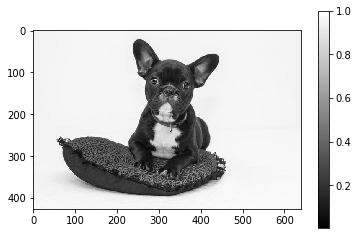

In [10]:
x /= 255.
plt.imshow(x,cmap='gray')
plt.colorbar();

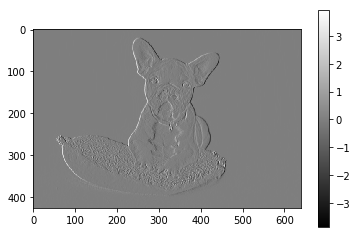

In [11]:
x_height, x_width = x.shape
W = np.array([[1,0,-1],
              [2,0,-2],
              [1,0,-1]]).reshape(1,1,3,3)
y = conv2d(x.reshape(1, 1, x_height, x_width), W, 1)

plt.imshow(y.reshape(x_height, x_width), cmap='gray')
plt.colorbar()

## Aplicando convolução 3x3 imagem colorida RGB 3 bandas


Lendo a imagem com PIL e visualizando pelo Jupyter

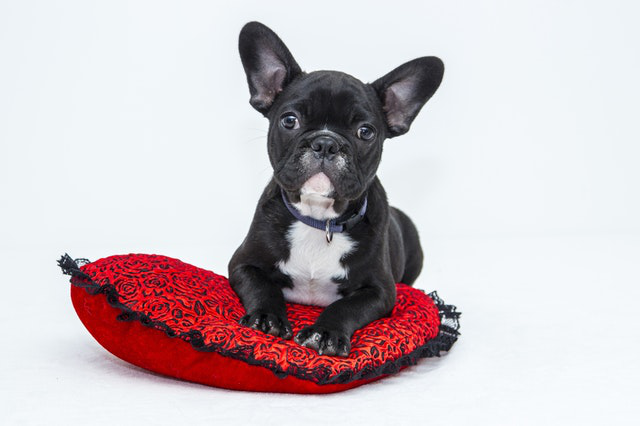

In [12]:
%matplotlib inline
from PIL import Image

x_pil = Image.open('/data/datasets/images/dog1.jpg')
x_pil

Convertendo imagem para NumPy e visualizando com o matplotlib

(426, 640, 3) uint8 0 255


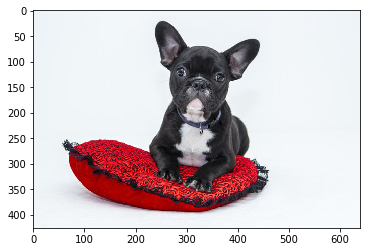

In [13]:
import matplotlib.pyplot as plt
x = np.array(x_pil)
print(x.shape, x.dtype, x.min(), x.max())
x = x / 255.
plt.imshow(x);

### Arrumação no shape da imagem

A imagem quando é lida, ela possui o formato dito "channels last": o seu shape é (height,width,3). O shape adequado para entrar na função `conv2d` feita acima
é o formato "channels first" e adicionalmente uma dimensão adicional das amostras: shape (1,3, height,width). 

Fazemos isso com as funções `transpose` e `newaxis`:

In [14]:
x_height,x_width,x_channels = x.shape
print('x.shape:', x.shape)
# formato inicial: (x_height, x_width, 3)
x1 = x.transpose(2, 0, 1)
print('x1.shape:', x1.shape)
x2 = x1[np.newaxis, :, :, :]
print('x2.shape:', x2.shape)

x.shape: (426, 640, 3)
x1.shape: (3, 426, 640)
x2.shape: (1, 3, 426, 640)


y.shape: (1, 1, 424, 638)


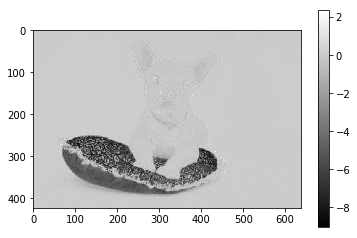

In [15]:
W = np.array([[[ 0,-1, 0],
               [-1,-4,-1],
               [ 0,-1, 0]],
              [[ 1, 2, 1],
               [ 2, 4, 2],
               [ 1, 2, 1]],
              [[ 0,-1, 0],
               [-1,-4,-1],
               [ 0,-1, 0]]]).reshape(1,3,3,3)
y = conv2d(x2, W)
print('y.shape:', y.shape)
plt.imshow(y.reshape(x_height-2, x_width-2),cmap='gray')
plt.colorbar();

## Exercícios

### Teórico

1. Supondo uma imagem de entrada 100 x 100 e um kernel 3 x 3. Sem utilizar o padding, a imagem de saída será de 98 x 98. 
Se fosse utilizar uma rede densa, com entrada de 100 x 100 e saída 98 x 98, quantos parâmetros seriam necessários para ser treinados? E no caso da rede convolucional? Qual é o fator de redução?

### Práticos

1. Nos exemplos anteriores, trocar o parâmetro ``padding`` para 1 e explicar a diferença.
2. Faça um exemplo numérico similar aos anteriores, porém com imagem de entrada com 3 canais, e 2 filtros de
   saída, utilizando kernel 3x3.
3. Altere o exemplo feito com uma imagem de cinza para processar agora duas imagens de mesmo tamanho.

## Aprendizados com este notebook